# Libraries used to get pretrained deIT

In [1]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms
from implemented_functions_to_use.helper_functions import set_seeds
from PIL import Image

### Testing which device used to train (CPU or GPU) 

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

## Save parameters as class

In [3]:
# Configure Model Parameters
class PARAM:
    EPOCHS = 30
    BATCH_SIZE = 32
    P = 0.5 #probability for Data Augmentation
    TF_SEED = 768
    HEIGHT = 224
    WIDTH = 224
    CHANNELS = 3
    IMAGE_MEAN = [0.456]     #for Data Augmentation
    IMAGE_STD_DEVIATION = [0.224]     #for Data Augmentation
    PROB = 0.5
    WEIGHT_DECAY = 0.01

# get pretraind model with his weight from torch

In [4]:
# Get pretrained weights for ViT-Base
model_swin_weights = torchvision.models.Swin_B_Weights.DEFAULT

# create a ViT model with pretrained weights
model_swin = torchvision.models.swin_b(weights=model_swin_weights).to(device)

# Disable Gradient
for parameter in model_swin.parameters():
    parameter.requires_grad = False
for parameter in model_swin.head.parameters():
    parameter.requires_grad = True
    
# Define the classifier head 
class_names = ['Astrocitoma T1','Meningioma T1','Neurocitoma T1','Papiloma T1','Schwannoma T1','NORMAL T1']

set_seeds()
model_swin.head = nn.Linear(in_features=1024, out_features=len(class_names)).to(device)
print(model_swin.head.out_features)

6


## Showing model layers

In [5]:
from torchinfo import summary

# Print a summary using torchinfo (uncomment for actual output)
summary(model=model_swin, 
        input_size=(PARAM.BATCH_SIZE, PARAM.CHANNELS, PARAM.HEIGHT, PARAM.WIDTH), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)
model_swin

SwinTransformer(
  (features): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
      (1): Permute()
      (2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    )
    (1): Sequential(
      (0): SwinTransformerBlock(
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (attn): ShiftedWindowAttention(
          (qkv): Linear(in_features=128, out_features=384, bias=True)
          (proj): Linear(in_features=128, out_features=128, bias=True)
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (mlp): MLP(
          (0): Linear(in_features=128, out_features=512, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=512, out_features=128, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (1): SwinTransformerBlock

## Setup directory paths to train and test images

In [6]:
train_dir = './archive_for_multiple_classes/train'
test_dir = './archive_for_multiple_classes/val'

# DATA AUGMENTATION

In [7]:
# Get automatic transforms from pretrained Swin weights
model_swin_transforms = model_swin_weights.transforms(mean=PARAM.IMAGE_MEAN, std=PARAM.IMAGE_STD_DEVIATION)

pre_train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=PARAM.PROB),            # Random horizontal flip
    transforms.RandomRotation(degrees=15),              # Random rotation
])

train_transform = transforms.Compose([
    model_swin_transforms,
    pre_train_transform
])

val_transform = model_swin_transforms

print(model_swin_transforms)
print(pre_train_transform)
print(train_transform)

ImageClassification(
    crop_size=[224]
    resize_size=[238]
    mean=[0.456]
    std=[0.224]
    interpolation=InterpolationMode.BICUBIC
)
Compose(
    RandomHorizontalFlip(p=0.5)
    RandomRotation(degrees=[-15.0, 15.0], interpolation=nearest, expand=False, fill=0)
)
Compose(
    ImageClassification(
    crop_size=[224]
    resize_size=[238]
    mean=[0.456]
    std=[0.224]
    interpolation=InterpolationMode.BICUBIC
)
    Compose(
    RandomHorizontalFlip(p=0.5)
    RandomRotation(degrees=[-15.0, 15.0], interpolation=nearest, expand=False, fill=0)
)
)


## TESTING TRANSFORMER (Data AUG)

In [8]:
test_train_img = 'C:\Users\ilyas\Detecting-Brain-Tumors-Using-Transformer-Model-master\archive_for_2_classes\train\yes/Y10.jpg'
image = Image.open(test_train_img)

def show_image(tensor, title="Test DA"):
    image = tensor.permute(1, 2, 0) # Convert from C x H x W to H x W x C for plotting
    plt.imshow(image, cmap="gray")
    plt.title(title)
    plt.axis('off')
    plt.show()

# Apply the data augmentation transformations multiple times to test
for i in range(5):  # Test augmentation 5 times
    augmented_image = train_transform(image)
    show_image(augmented_image, title=f"Augmented Image {i+1}")

SyntaxError: (unicode error) 'unicodeescape' codec can't decode bytes in position 2-3: truncated \UXXXXXXXX escape (3743041575.py, line 1)

## Data augmenting Images

In [9]:
# Function to check if a folder has less than 200 images and augment if necessary
def augment_folder(folder_path: str, num_images_required: int = 200):
    current_images = os.listdir(folder_path)
    num_images = len(current_images)
    
    if num_images < num_images_required:
        print(f"Folder {folder_path} has {num_images} images. Augmenting...")
        
        # Basic augmentations (you can add more)
        augment_transform = transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.5),
            # transforms.RandomRotation(degrees=45),
            transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5),
            transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5.))
        ])

        # Create new images until reaching the desired amount
        while num_images < num_images_required:
            image_to_augment = random.choice(current_images)
            image_path = os.path.join(folder_path, image_to_augment)
            image = Image.open(image_path)
            
            # Apply transformations and save the augmented image
            augmented_image = augment_transform(image)
            new_image_name = f"aug_{num_images}.jpg"
            augmented_image.save(os.path.join(folder_path, new_image_name))
            num_images += 1
        print(f"Folder {folder_path} now has {num_images} images.")

# Function to augment images for all classes in a dataset folder
def augment_dataset_folder(root_dir: str, num_images_required: int = 200):
    for class_folder in os.listdir(root_dir):
        class_folder_path = os.path.join(root_dir, class_folder)
        if os.path.isdir(class_folder_path):
            augment_folder(class_folder_path, num_images_required)

## Turning images into DataLoaders using the create_dataloaders()

In [10]:
import os
import random
from torchvision import datasets, transforms
from torch.utils.data import DataLoader


In [11]:
NUM_WORKERS = os.cpu_count()

def create_dataloaders(
    train_dir: str, 
    test_dir: str, 
    train_transform: train_transform,
    val_transform: val_transform,
    batch_size: int, 
    num_workers: int=NUM_WORKERS,
    augment: bool=True
):

    # Augmenting images of class directories which is less than 200 images 
    if augment:
        augment_dataset_folder(train_dir)
        augment_dataset_folder(test_dir,int(50))
    # Use ImageFolder to create dataset(s)
    train_data = datasets.ImageFolder(train_dir, transform=train_transform)
    test_data = datasets.ImageFolder(test_dir, transform=val_transform)
    
    # Get class names
    class_names = train_data.classes
    
    # Turn images into data loaders
    train_dataloader = DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      pin_memory=True,
    )
    test_dataloader = DataLoader(
      test_data,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      pin_memory=True,
    )
    
    return train_dataloader, test_dataloader, class_names

In [12]:
# Setup dataloaders
train_dataloader, test_dataloader, class_names = create_dataloaders(train_dir=train_dir,
                                                                                     test_dir=test_dir,
                                                                                     train_transform=train_transform,
                                                                                     val_transform=val_transform,
                                                                                     batch_size=PARAM.BATCH_SIZE) # Could increase if we had more samples, such as here: https://arxiv.org/abs/2205.01580 (there are other improvements there too...)


In [13]:
# # for name, param in model_swin.named_parameters():
# #     if param.requires_grad:
# #         print(f"{name} requires grad.")
# #     # else:
# #     #     print(f"{name} does not require grad.")
# # inputs, labels = next(iter(train_dataloader))

# # # Forward pass
# # outputs = model_swin(inputs.to(device))

# # # Print shapes of outputs and labels
# # print(f"Outputs shape: {outputs.shape}")
# # print(f"Labels shape: {labels.shape}")
# # # Example
# loss = loss_fn(outputs, labels.to(device))
# print(loss)

## Traing model and save results as dictionary

In [13]:
from implemented_functions_to_use.going_modular import engine

for param in model_swin.features.parameters():  
    param.requires_grad = False

# Unfreeze the classification head
for param in model_swin.head.parameters():
    param.requires_grad = True

# for name, param in model_swin.named_parameters():
#     if param.requires_grad:
#         print(f"{name}: requires_grad={param.requires_grad}")

optimizer = torch.optim.Adam(params=[p for p in model_swin.parameters() if p.requires_grad],  
                             lr=1e-3,
                             weight_decay=PARAM.WEIGHT_DECAY # To reduce the risk of overfitting
                            )
loss_fn = torch.nn.CrossEntropyLoss()

# Train the classifier head of the pretrained ViT feature extractor model
set_seeds()
swin_model_results = engine.train(model=model_swin,
                                      train_dataloader=train_dataloader,
                                      test_dataloader=test_dataloader,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=PARAM.EPOCHS,
                                      device=device)


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.4571 | train_acc: 0.4541 | test_loss: 1.1895 | test_acc: 0.5969
Epoch: 2 | train_loss: 1.0957 | train_acc: 0.6242 | test_loss: 1.0633 | test_acc: 0.6062
Epoch: 3 | train_loss: 0.9380 | train_acc: 0.6996 | test_loss: 1.0159 | test_acc: 0.6062
Epoch: 4 | train_loss: 0.8631 | train_acc: 0.7065 | test_loss: 0.9715 | test_acc: 0.6312
Epoch: 5 | train_loss: 0.7960 | train_acc: 0.7482 | test_loss: 0.9054 | test_acc: 0.6594
Epoch: 6 | train_loss: 0.7586 | train_acc: 0.7514 | test_loss: 0.8830 | test_acc: 0.6875
Epoch: 7 | train_loss: 0.7390 | train_acc: 0.7387 | test_loss: 0.9160 | test_acc: 0.6719
No improvement for 1 epoch(s).
Epoch: 8 | train_loss: 0.6939 | train_acc: 0.7804 | test_loss: 0.8702 | test_acc: 0.6750
Epoch: 9 | train_loss: 0.6851 | train_acc: 0.7776 | test_loss: 0.8749 | test_acc: 0.6781
No improvement for 1 epoch(s).
Epoch: 10 | train_loss: 0.6603 | train_acc: 0.7786 | test_loss: 0.8728 | test_acc: 0.6781
No improvement for 2 epoch(s).
Epoch: 11 | trai

## Save model results as file

In [14]:
import pickle

# Saving the model
with open('swin_model_results.pkl', 'wb') as file:
    pickle.dump(swin_model_results, file)

print("Model results saved successfully!")


Model results saved successfully!


## Save model  as file

In [15]:
import pickle

# Saving the model
with open('swin_model.pkl', 'wb') as file:
    pickle.dump(model_swin, file)

print("Model saved successfully!")


Model saved successfully!


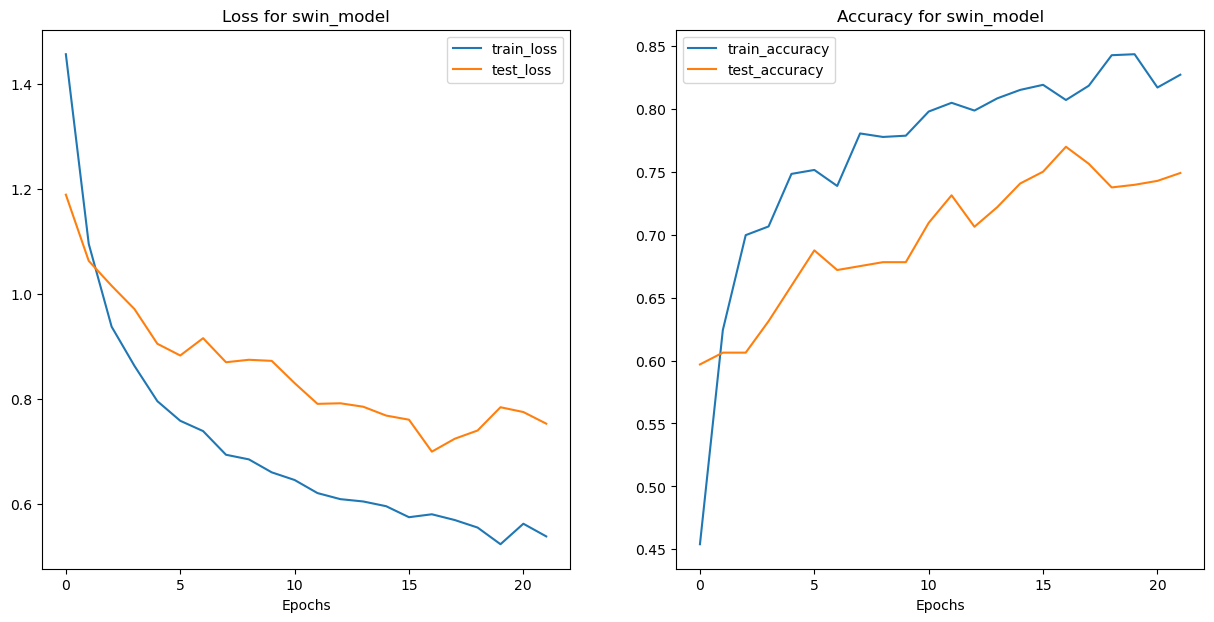

In [16]:
# Plot the loss curves
from implemented_functions_to_use.helper_functions import plot_loss_curves,plot_roc_auc,plot_confusion_matrix 

plot_loss_curves('swin_model',swin_model_results) 

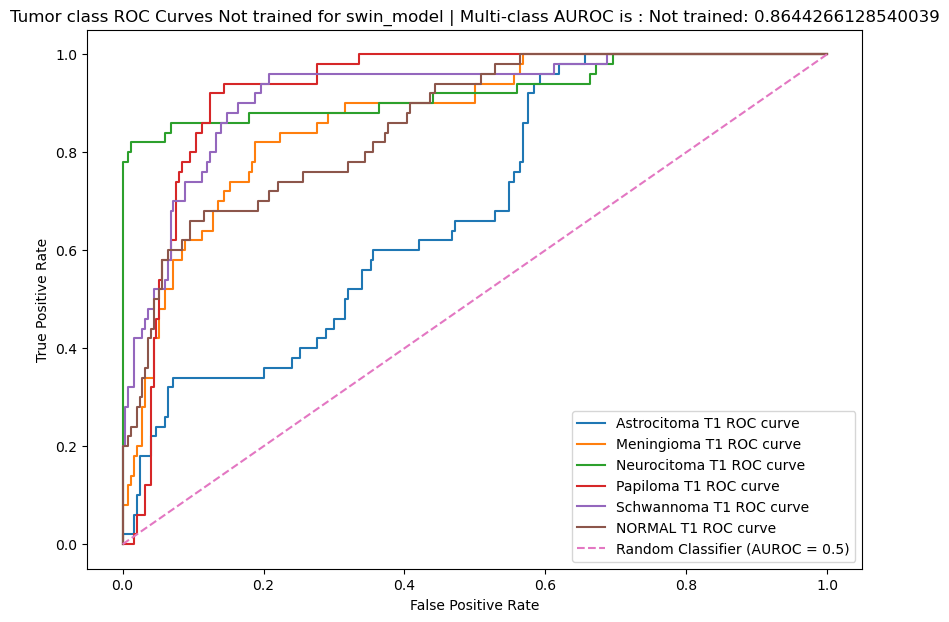

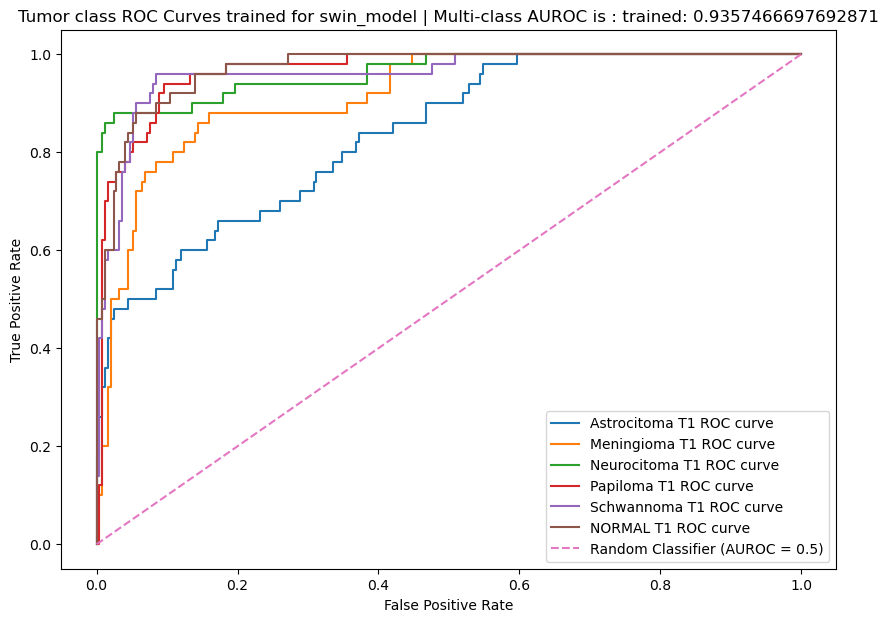

In [17]:
class_names = ['Astrocitoma T1','Meningioma T1','Neurocitoma T1','Papiloma T1','Schwannoma T1','NORMAL T1']
plot_roc_auc('swin_model',swin_model_results,len(class_names),class_names,False)
plot_roc_auc('swin_model',swin_model_results,len(class_names),class_names,True)


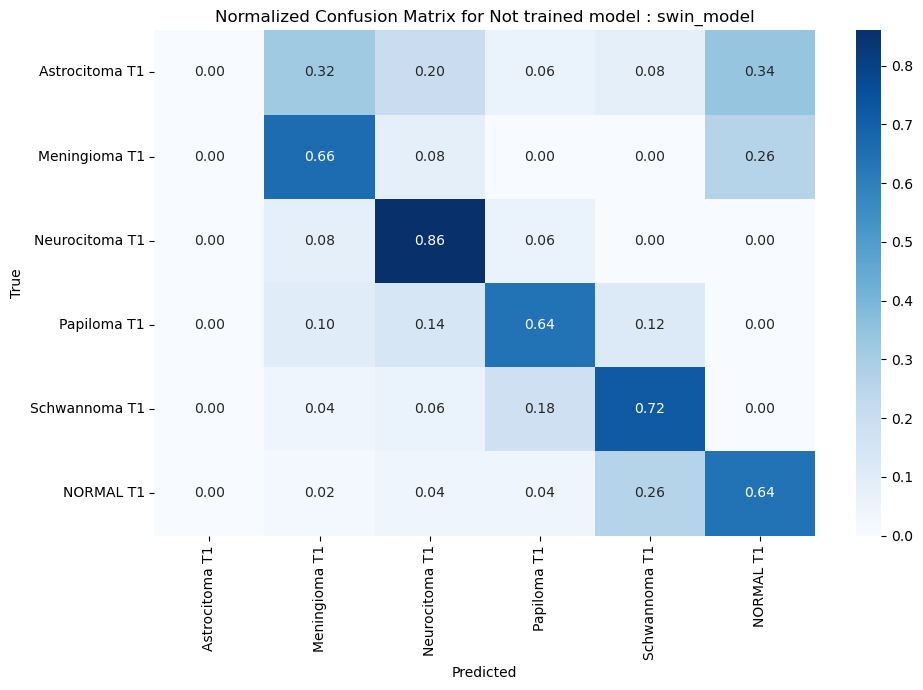

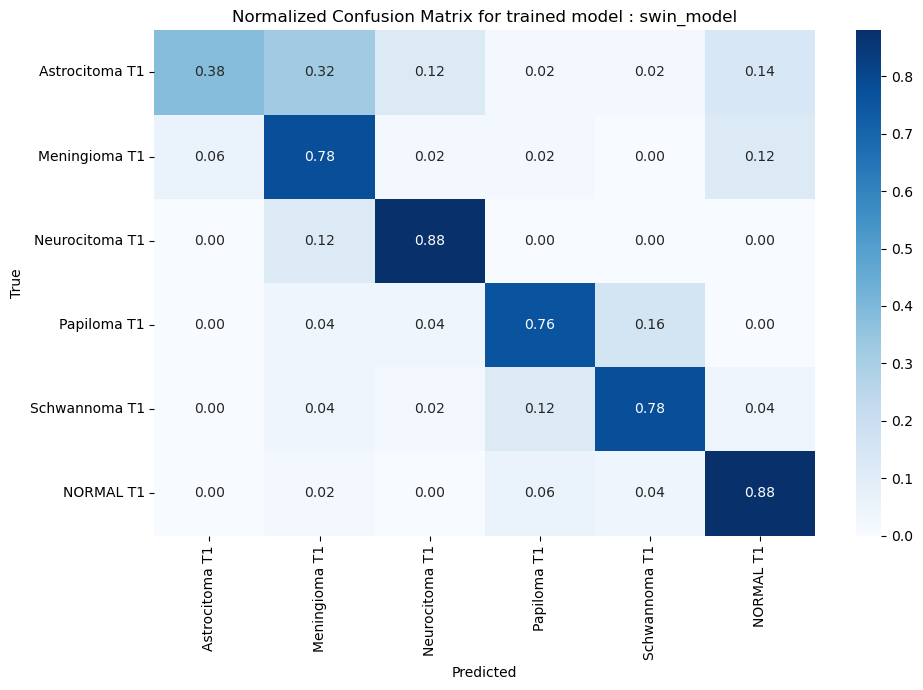

In [18]:
plot_confusion_matrix('swin_model',swin_model_results,class_names,False)
plot_confusion_matrix('swin_model',swin_model_results,class_names,True)

### Predict all images within predict folder

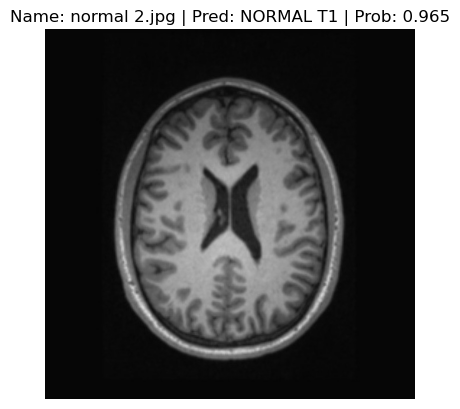

In [19]:
import requests

# Import function to make predictions on images and plot them 
from implemented_functions_to_use.going_modular.predictions import pred_and_plot_image

# Setup custom image path
custom_image_path = "./predict/normal 2.jpg"

# Predict on custom image
pred_and_plot_image(model=model_swin,
                    image_path=custom_image_path,
                    class_names=class_names)

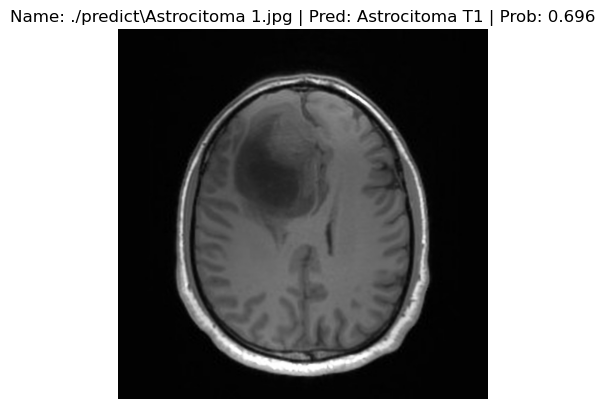

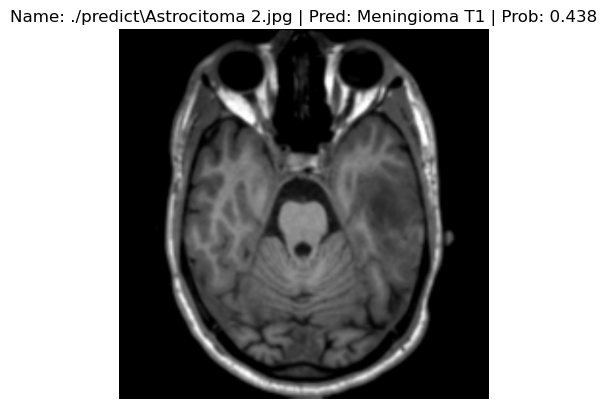

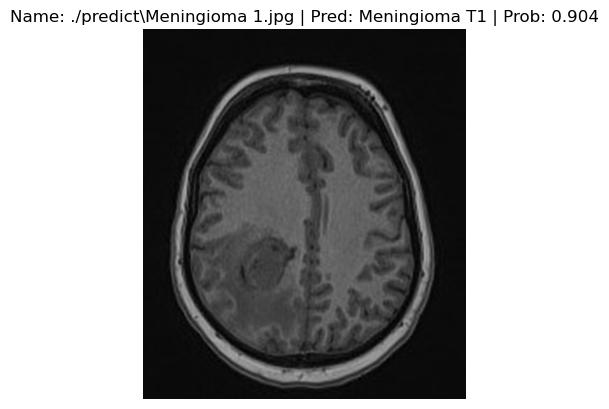

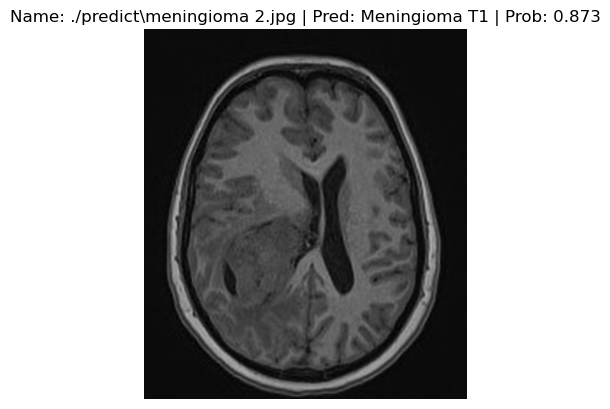

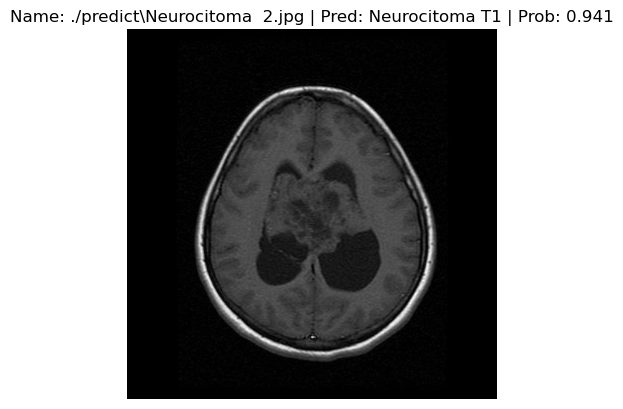

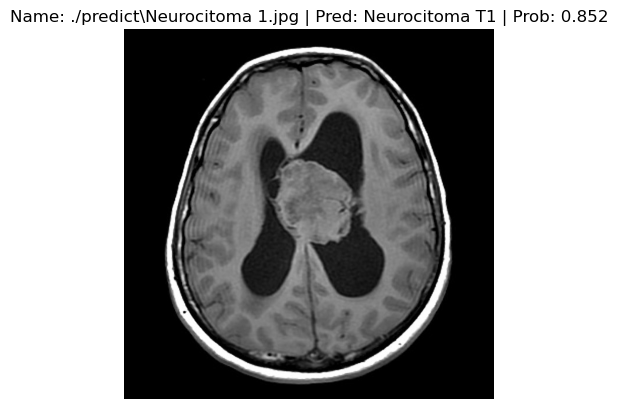

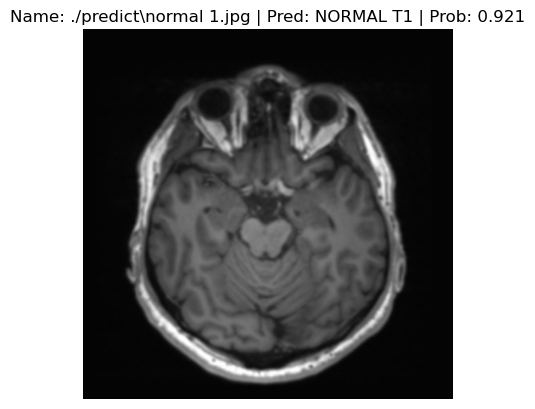

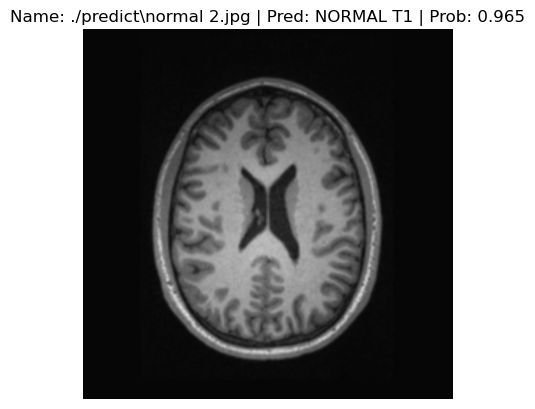

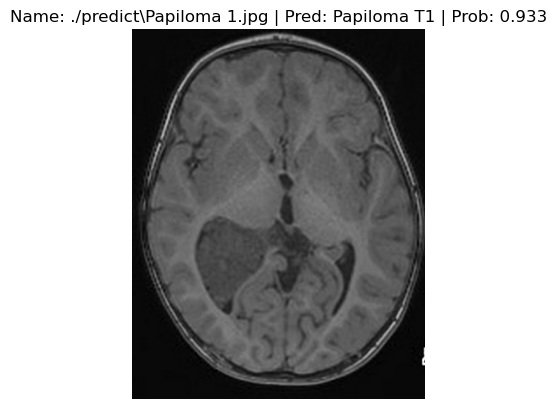

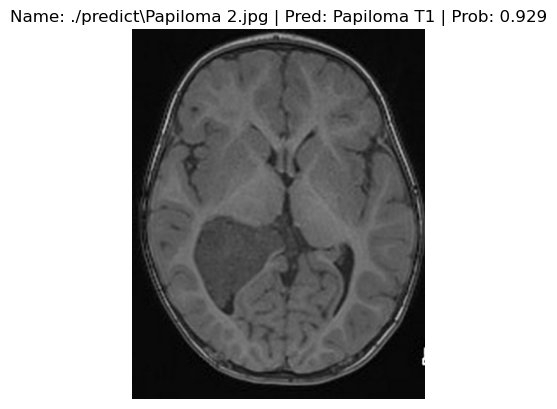

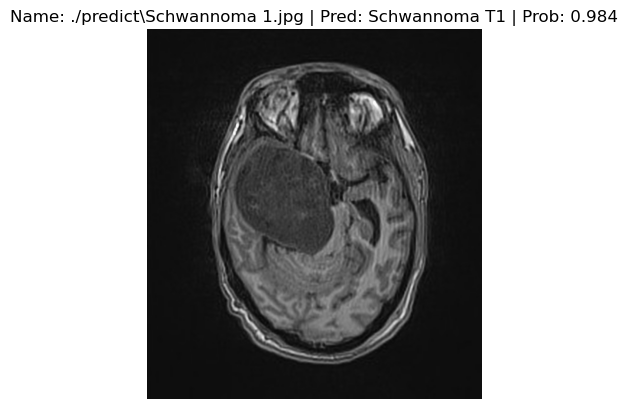

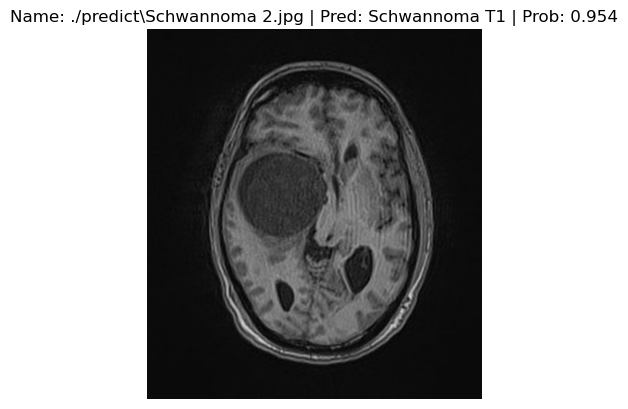

In [20]:
import glob

predict_path = './predict/*.jpg'
for image_path in glob.iglob(predict_path):
    pred_and_plot_image(model=model_swin,
                    image_path=image_path,
                    class_names=class_names)
    


# Load model as file

In [22]:
# import pickle
# # Loading the model
# with open('swin_model_results.pkl', 'rb') as file:
#     swin_model_results = pickle.load(file)

# print("Loaded swin_model_results:", swin_model_results)


In [23]:
# # Loading the model
# with open('swin_model.pkl', 'rb') as file:
#     swin_model = pickle.load(file)

# print("Loaded swin_model:", swin_model)


In [24]:
# import requests

# # Import function to make predictions on images and plot them 
# from implemented_functions_to_use.going_modular.predictions import pred_and_plot_image

# # Setup custom image path
# custom_image_path = "./predict/normal 2.jpg"

# # Predict on custom image
# pred_and_plot_image(model=loaded_model,
#                     image_path=custom_image_path,
#                     class_names=class_names)

In [25]:
# import glob
# predict_path = './predict/*.jpg'
# for image_path in glob.iglob(predict_path):
#     pred_and_plot_image(model=loaded_model,
#                     # image_path=image_path,
#                     class_names=class_names)
    